# Optimization Homework 3
Here are just some simple codes for the homework.
I follow [Numerical Recipes in C](https://www.cec.uchile.cl/cinetica/pcordero/MC_libros/NumericalRecipesinC.pdf)
for the overall algorithm.

For the first part of the problem we find the linear approximation of this set of points.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import line_search
from sklearn.linear_model import LinearRegression # For comparision

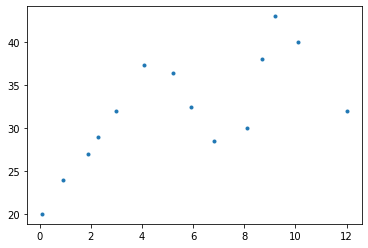

In [3]:
X = np.array([0.1, 0.9, 1.9, 2.3, 3, 4.1, 5.2, 5.9, 6.8, 8.1,
    8.7, 9.2, 10.1, 12])
Y = np.array([20, 24, 27, 29, 32, 37.3, 36.4, 32.4, 28.5,
             30, 38, 43, 40, 32])
plt.plot(X, Y, '.')

# Variance
In the book they assume that each point has its own variance $\sigma_i$, but here we just use the same $\sigma$ for all the points.

The terms of the formula are:
$$ S = \sum_{i=1}^{N}\frac{1}{\sigma^2_i}\quad S_x=\sum_{i=1}^{N}\frac{x_i}{\sigma^2_i} \quad S_y = \sum_{i=1}^{N}\frac{y_i}{\sigma_i^2}$$
$$S_{xx} = \sum_{i=1}^{N}\frac{x_i^2}{\sigma_i^2}\quad S_{xy}=\sum_{i=1}^{N}\frac{x_i y_i}{\sigma_i^2}$$

In [3]:
def optimize(X, Y):
    m, b = 0, 0
    npoints = X.shape[0]
    iterations = 5
    lr = 0.01
    i = 0
    while i < iterations:
        preds = X * m + b
        dm =(-2/npoints)* np.sum(X * (Y - preds))
        db = (-2/npoints)*(np.sum(Y - preds))
        m -= (dm * lr)
        b -= (db * lr)
        
        i += 1
    return m, b

## Plot the Estimate Line
Initial estimate given arbitrary variance.

4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394
4.281364105279622 1.2622328750877394


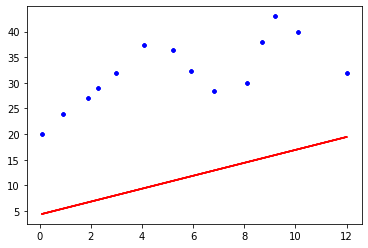

In [4]:
i = 0
while i < 5:
    a, b = optimize(X, Y)
    print(a,b)
    preds = X * b + a
    #var = np.sum(np.power(Y - preds, 2) / (N - M)) 
    #print(var)
    plt.plot(X, Y, 'b.')
    plt.plot(X, preds, 'r')
    i += 1
plt.show()

## `sklearn`'s Linear Regression for comparison

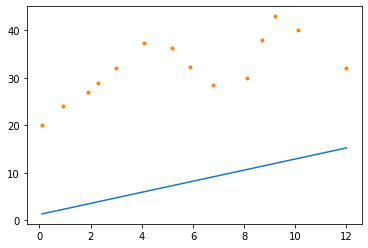

In [5]:
model  = LinearRegression().fit(X.reshape(-1, 1), Y)
plt.plot(X, X * model.coef_ + b)
plt.plot(X, Y, '.')
plt.show()


## Quadratic Regression
The quadratic function is 
$$f(x) = ax^2 + bx + c$$

To find the optimal $(a, b, c)$, we can solve the system of equations
$$ a\sum x_i^4 + b\sum x_i^3 + c\sum x_i^2 = \sum x_i^2 y$$
$$ a\sum x_i^3 + b\sum x_i^2 + c\sum x_i = \sum x_i y$$
$$ a\sum x_i^2 + b\sum x_i + cn_i = \sum y_i$$

We use an online solver to arrive at the optimal values of $a, b, c$.

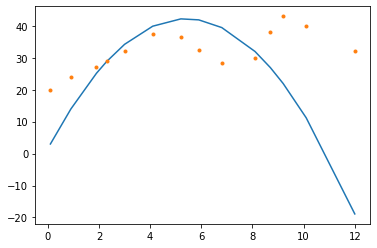

In [6]:
a = -1.4
b = 15.1
c = 1.51
preds = a * np.power(X, 2) + b * X + c

plt.plot(X, preds)
plt.plot(X,Y, '.')
plt.show()

# 2
Using Fletcher-Reeves, and either Newton or Quasi-Newton method, find the best fit linear and quadratic lines numerically.

## Fletcher Reeves


1068.9471428571428
[1.9806149  0.32707996] [-1.07511331 -0.21112937]
[1.98610578 0.32812118] [-1.07664178 -0.21132561]
[1.97849204 0.32666276] [-1.07411879 -0.21100162]
[1.98831007 0.32855347] [-1.07761805 -0.21145102]
[1.97642684 0.32625662] [-1.07310513 -0.21087141]
[1.99058693 0.32899976] [-1.07856781 -0.21157302]
[1.97445096 0.32586774] [-1.07205811 -0.21073691]
[1.99296707 0.32946607] [-1.07947652 -0.21168975]
[1.97259621 0.32550236] [-1.0709636  -0.21059632]
[1.99548096 0.3299584 ] [-1.08032953 -0.21179933]


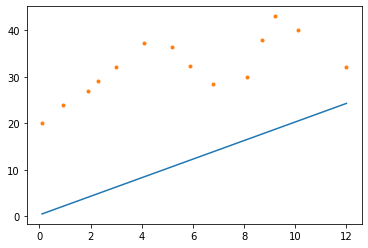

In [8]:
# Quadratic regression error gradient
def error(Y, preds):
    return np.sum(np.power(Y-preds, 2)) / Y.shape[0]

def objective(x, y, preds, p):
    N = x.shape[0]
    preds = p[0] * np.power(x, 2) + p[1] * x  + p[2]
    ret =  (1/14) * np.sum(np.power((y - preds), 2))
    print(ret)
    return ret*.001

def gradient(x, y, preds, guess):
    
    size = preds.shape[0]
    den = -2 / size
    preds = guess[0] * np.power(x, 2) + guess[1] * x + guess[2]
    dyda = np.sum((y - preds)*(x.T * x)) * den
    dydb = np.sum((y - preds)*x) * den
    dydc = np.sum((y-preds)) * den
    return np.array([dyda, dydb, dydc]) / (size * size)

def linear_gradient( x, y, preds, guess):
    size = x.shape[0]
    den = -2/size
    preds = guess[0] * X + guess[1]
    dydw = np.sum((y - preds)*x) *den
    dyda = np.sum((y - preds)) * den
    ret = np.array([dydw, dyda])
    return ret / (size * size)

def get_lambda(guess, S):
    denom = S / np.linalg.norm(S, ord=2)
    a = -guess[0]  * denom
    b = -guess[1] * denom
    c = -guess[2] * denom
    ret =  np.array([np.linalg.norm(a),
                     np.linalg.norm(b),
                     np.linalg.norm(c)]) 
    return ret

tol = 0.5
#Basically get the first iteration
guess = np.array([0, 0])
preds = X * guess[0] + guess[1]

grad = linear_gradient(X, Y, preds, guess)
S = -grad

print(error(Y, preds))
guess = guess + (S)
i = 0
lamb = .002
# TODO: Still need to find lambda better
while i < 10:
    prev_grad = grad
    grad = linear_gradient(X, Y, preds, guess)
    S = -grad + ((np.power(np.linalg.norm(grad),2))/(np.power(np.linalg.norm(prev_grad),2)))*S
    lamb *= -1
    
    guess = guess + (lamb * S)
    preds = guess[0] * X + guess[1]
    print(guess, grad)
    i += 1
    
plt.plot(X, preds)
plt.plot(X, Y, '.')

### Fletcher-Reeves on Quadratic Function
The procedure is the same, except we add the quadratic term in our loss function, and our gradient.

664.4330205104947
[0.31493665 0.04062468 0.0070531 ]
457.0204824772045
[0.3726974  0.05055829 0.00942227]
428.00058216171743
[0.3945229  0.0566942  0.01134962]
423.62744318563335
[0.40317375 0.06159407 0.01318277]
422.75620446416843
[0.40760601 0.06689932 0.01533295]
422.3483326337318
[0.41063603 0.07477066 0.01864209]
421.8761618180709
[0.41218886 0.08802362 0.02433285]
421.04314574536085
[0.41076318 0.10896814 0.03345689]
419.5132807478461
[0.40532769 0.13478965 0.04482977]
417.3787733181586
[0.39837295 0.1571643  0.05476142]


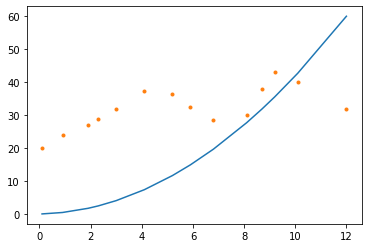

In [184]:
guess = np.array([0, 0, 0]) # Initial point
preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]
grad = gradient(X, Y, preds, guess)
S = -grad
lamb = .01
guess = guess +(lamb * S)
i = 0

while i < 10:
    preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]
    prev_grad = grad
    grad = gradient(X, Y, preds, guess)
    S = -grad + (np.dot(grad, grad) / np.dot(prev_grad, prev_grad))*S
    #print(lamb.shape, S.shape)
    guess = guess + (lamb * S)
    print(error(Y, preds))
    print(guess)
    i += 1
plt.plot(X, preds)
plt.plot(X, Y, '.')

## Armijo's Line Search
For a given point $x$, calculate $f(\lambda)$ and compare it to $f(x) + \lambda\epsilon f'(x)$ to determine if we should reduce $\lambda$ or
increase it.

In [195]:
# replace f(0) with norm of f for many dimensions?
def armijo(x, y, preds, guess):
    lamb = np.array([1,1, 1])
    eps = 0.2
    flamb = objective(x, y, preds, lamb) # Objective with our own guess 
    forig = objective(x, y, preds, guess) # Original objective value
    grad = gradient(x, y, preds, guess)
    i = 0

    if flamb <= forig + np.linalg.norm(lamb * eps * grad):
        while flamb <= forig + np.linalg.norm(lamb * eps * grad):
            lamb = lamb * 2
            flamb = objective(x, y, preds, lamb)
            print('\tMinimizing')
            print(lamb)

    else:
        while flamb > forig + np.linalg.norm(lamb * eps * grad):
            lamb = lamb / 2
            flamb = objective(x, y, preds, lamb)
            print('\tMaximizing')
            print(lamb)
    return lamb
    #print(flamb, forig, grad)
    

## Quasi-Newton's Method
With quasi-Newton methods, we try to approximate the original Hessian matrix $H$ of second order partial derivatives with another matrix $B$.

Here we try the BFGS method.


[0 0] [-0.19839431 -0.03276968]
2.010824608306412


[-0.19839431 -0.03276968] [-0.27453802  0.06463387]
2.1023948971384123


[-0.27453802  0.06463387] [-0.04571636  0.46952806]
2.131165492453578


[-0.04571636  0.46952806] [-1.56342387 -0.88296506]
2.0042687701336805


[-1.56342387 -0.88296506] [2.42700744 3.33845207]
2.7687471508579793


Tolerance reached


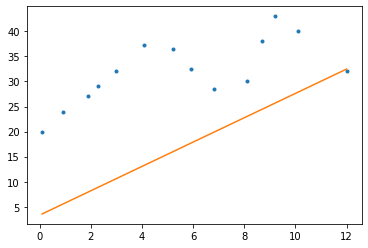

In [193]:
tol = 0.5
guess = np.array(([0, 0]))
B = np.eye(guess.shape[0]) # nxn Identity matrix
next_guess = guess
i = 0
while i < 10:
    preds = guess[0] * X + guess[1] 
    grad = linear_gradient(X, Y, preds, guess)

    if np.linalg.norm(grad) < 1:
        print('Tolerance reached')
        break

    S = -np.matmul(B, grad) # Initial Search Direction
    lamb = -.1 # Initial step along line
    next_guess = guess + (lamb * S)
    g = linear_gradient(X, Y, preds, next_guess) - grad
    d = next_guess - guess
    M = 1 + np.matmul(np.matmul(g.T, B), g) / (np.dot(d.T, g))

    N = -(np.matmul(d, np.matmul(g.T, B))) / (np.dot(d.T, g))

    Q = -(np.matmul(np.matmul(B, g), d.T)) / (np.dot(d.T, g))
    B = B + M + N + Q
    print(guess, next_guess)
    #print(objective(X, Y, preds, guess))
    print(np.linalg.norm(grad))
    guess = next_guess
    print('\n')
    i += 1
plt.plot(X, Y, '.')
plt.plot(X, preds, '-')
plt.show()

## Quadratic BFGS
Run the same algorithm with a quadratic approximation

[1.58804031e-04 1.98394315e-05 3.27696793e-06] [1.58804031e-04 1.98394315e-05 3.27696793e-06] 16.007205158687718 16.000977231275293
[0.00721448 0.00693661 0.00690349] [0.00721448 0.00693661 0.00690349] 16.000977231275293 15.696857207796736
tolerance also reached
Best guess: [0.30563728 0.30522321 0.30517381]


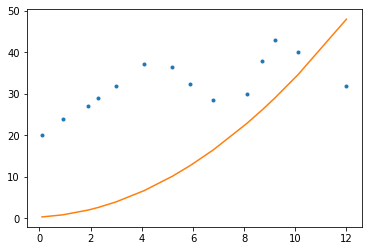

In [216]:
tol = 3
guess = np.array(([0, 0, 0]))
B = np.eye(guess.shape[0]) # nxn Identity matrix
next_guess = guess
lamb = 0.00001
i = 0
while i < 5:
    preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]

    grad = gradient(X, Y, preds, guess)
    if np.linalg.norm(grad) < tol:
        print('tolerance reached')
        break
    S = -np.matmul(B, grad)
    #lamb = armijo(X,Y, preds, guess)
    next_guess = guess + (lamb * S)
    next_grad = gradient(X, Y, preds, next_guess)

    if np.linalg.norm(next_grad) < tol:
        print('tolerance also reached')
        break
    #print(np.linalg.norm(next_grad))
    g = next_grad - grad
    d = next_guess - guess
    M = 1 + np.matmul(np.matmul(g.T, B), g) / (np.dot(d.T, g))

    N = -(np.matmul(d, np.matmul(g.T, B))) / (np.dot(d.T, g))

    Q = -(np.matmul(np.matmul(B, g), d.T)) / (np.dot(d.T, g))
    B = B + M + N + Q
    guess = next_guess
    print(guess, next_guess, np.linalg.norm(grad), np.linalg.norm(next_grad))
    preds = guess[0] * np.power(X, 2) + guess[1] * X + guess[2]

    i += 1
    
print(f'Best guess: {next_guess}')
preds = next_guess[0] * np.power(X, 2) + next_guess[1] * X + next_guess[2]
plt.plot(X, Y, '.')
plt.plot(X, preds )
plt.show()

# 3. Polynomial Regression
Decide the order of the polynomial that best fits the data points. We use numpy to find the regression order that minimizes the least squares error.

67.35301175472965
56.638255051541655
19.554829414701285
55.24898586567353
58.84033100349392
13.863051161043396


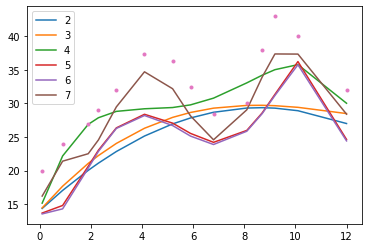

In [13]:
def get_preds(X, Y, cos):
    exp = cos.shape[0] - 1
    preds = np.array((X.shape))
    for i, exp in enumerate(range(exp, 0, -1)):
        preds = preds +(cos[i] * np.power(X, exp))
    return preds
        
        
max_deg = 8
for deg in range(2, max_deg):
    coeff = np.polyfit(X, Y, deg)
    preds = get_preds(X, Y, coeff)
    plt.plot(X, preds, '-', label=deg)
    print(error(Y, preds))
plt.plot(X, Y, '.')
plt.legend()
plt.show()

## 4. Create our own model
Use your creativity to construct the regression model (i.e. combining polynomial, sin, cos, exponential, and/or log functions) which best fits the data. For example, you may assume that $y = c_1\sin(x) + c_2e^x$ , where $c_1$ and $c_2$ are the coefficients to be determined. Also, describe your reasons for choosing certain functions in your model.